## Mimicking Agent 1 With A ConvNet

### Imports and Settings

In [ ]:
import pickle
import warnings

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
warnings.filterwarnings('ignore')

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Hyperparameters

NUM_COLS = 25

# Change the base path as per location of the files in your drive

DATA_PATH = "/content/gdrive/MyDrive/CS520/agent3_centered/agent_3_ckpt_31.pkl"

In [ ]:
data = pickle.load(
    open(DATA_PATH, "rb")
)

X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((446252, 50), (446252, 4), (49584, 50), (49584, 4))

In [ ]:
X_train = np.reshape(X_train, (-1, 5, 5, 2))
X_test = np.reshape(X_test, (-1, 5, 5, 2))

In [ ]:
del data

### Load Data

In [ ]:
%%time

movement_snaps = pd.read_csv(MOVEMENT_SNAPS_PATH)
position_snaps = pd.read_csv(POSITION_SNAPS_PATH, names=['run_number','x_coord', 'y_coord']).astype(int)
knowledge_snaps = pd.read_csv(KNOWLEDGE_SNAPS_PATH, header=None).astype(int)

CPU times: user 1min 59s, sys: 10.3 s, total: 2min 10s
Wall time: 2min 10s


In [ ]:
knowledge_snaps.shape, movement_snaps.shape, position_snaps.shape

((180604, 2500), (180604, 5), (180604, 3))

### Data Transformation

In [ ]:
# Get one-hot labels in the pre-decided order

if "Unnamed: 0" in movement_snaps.columns:
    movement_snaps.drop("Unnamed: 0", axis=1, inplace=True)
    
y = movement_snaps[["U", "D", "L", "R"]].astype(float).values

In [ ]:
# Rename knowledge snaps to 'X'

X = knowledge_snaps.values
del knowledge_snaps  # Necessary to avoid kernel crash

X.shape

(180604, 2500)

In [ ]:
# Convert 1D numpy array samples to 2D array samples

X = np.reshape(X, (-1, NUM_COLS, NUM_COLS))
X.shape

(180604, 50, 50)

In [ ]:
def get_position_vector(num_cols, position_snaps, idx, model_type="dense"):
    """ 
    Gets the position vector for 1 sample.
    1D for Dense NN and 2D for ConvNet.
    
    Parameters
    ----------
    num_cols: int
        Dimension of the grid. E.g. '50' for 50x50 grid
    position_snaps: pd.DataFrame
        Should have columns 'x_coord' and 'y_coord'
    idx: int
        Index for which to generate position vector.
    model_type: str
        "dense" or "conv"
        
    Returns
    -------
    position_vector: np.array
        1D array for dense and 2D array for Conv
    """
    
    if model_type not in ("dense", "conv"):
        raise ValueError("model_type =", model_type, "not acceptable")
    
    # Initialize position as 2D array of zeros
    position_vector = np.zeros((num_cols, num_cols))

    # Change position to 1
    pos_x, pos_y = position_snaps[['x_coord', 'y_coord']].iloc[idx].values
    position_vector[pos_x][pos_y] = 1.

    # If model type is dense, reshape to 1D array
    if model_type == "dense":
        position_vector = np.reshape(position_vector, -1)

    return position_vector

In [ ]:
# Create checkpoint

with open('../data/agent_1_conv_ckpt_1.pkl', 'wb') as f:
    pickle.dump((X, y), f)

In [ ]:
with open('../data/agent_1_conv_ckpt_1.pkl', 'rb') as f:
    X, y = pickle.load(f)
    
X.shape, y.shape

((180604, 2500), (180604, 4))

In [ ]:
# Create position vectors for each sample
position_vectors = \
    np.array(
        [
            get_position_vector(NUM_COLS, 
                                position_snaps, 
                                i,
                                model_type="conv") 
            for i in range(position_snaps.shape[0])
        ]
)

X_comb = []

for i in range(X.shape[0]):
    X_comb.append([X[i], position_vectors[i]])
    
X_comb = np.array(X_comb)

# Rename X_comb to X
X = X_comb
del X_comb

In [ ]:
assert X.shape[0] == y.shape[0], "No. of samples in X and y don't match!"

In [ ]:
# Checkpoint no. 2

with open('../data/agent_1_conv_ckpt_2.pkl', 'wb') as f:
    pickle.dump({'X': X, 'y': y, 'position_snaps': position_snaps}, f)

In [ ]:
with open('../data/agent_1_ckpt_2.pkl', 'rb') as f:
    data = pickle.load(f)
    X = data['X']
    y = data['y']
    
    
X.shape, y.shape

### Train-Test Split

In [ ]:
# Used for segregating the data into train and test sets

run_index = position_snaps["run_number"].astype(int).values

In [ ]:
# Select indices for train and test

train_indices = np.where(run_index < 900)[0]
test_indices = np.where(run_index >= 900)[0]

In [ ]:
assert not set(train_indices).intersection(set(test_indices)), "Train and test indices are not exclusive!"

In [ ]:
# Separate train and test sets

X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

In [ ]:
# Necessary to avoid kernel crash

del X, y

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, agent_paths_test.shape

((162658, 2, 50, 50), (162658, 4), (17946, 2, 50, 50), (17946, 4), (17946, 3))

In [ ]:
# Convert grid from channels-first to channels last for CNN input

X_train = np.moveaxis(X_train, 1, 3)
X_test = np.moveaxis(X_test, 1, 3)

X_train.shape, X_test.shape

((162658, 50, 50, 2), (17946, 50, 50, 2))

In [ ]:
# Checkpoint no. 3

with open('../data/agent_1_conv_ckpt_3.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 
                 'y_train': y_train, 
                 'X_test': X_test, 
                 'y_test': y_test, 
                 'agent_paths_test': agent_paths_test}, 
                f)

In [ ]:
X_train = np.reshape(X_train, (-1, 25, 25, 1))
X_test = np.reshape(X_test, (-1, 25, 25, 1))

X_train.shape, X_test.shape

((435913, 25, 25, 1), (48435, 25, 25, 1))

### Model Training

In [ ]:
BASE_PATH = "/content/gdrive/MyDrive/CS520/agent3_centered/"
with open(BASE_PATH+'agent_3_ckpt_31.pkl', 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

In [ ]:
def build_model(input_dim):
    """
    Builds a CNN with input dim.
    For Agent 1: (50, 50, 2)
    For Agent 3: (50, 50, 4) (for e.g.)
    """
    model =  tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (2, 2), activation="relu", input_shape=input_dim))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(16, (2, 2), activation="relu"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(300, activation="relu"))
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    model.add(tf.keras.layers.Dense(4, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
X_train.shape[1:]

(5, 5, 2)

In [ ]:
# Build model

warnings.filterwarnings('ignore')

model = build_model(X_train.shape[1:])

In [ ]:
# Early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Train Model

with tf.device('/device:GPU:1'):
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=512, 
                        epochs=20, 
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        use_multiprocessing=True)

Epoch 1/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6233 - accuracy: 0.7094 - val_loss: 0.6485 - val_accuracy: 0.7005
Epoch 2/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6234 - accuracy: 0.7087 - val_loss: 0.6482 - val_accuracy: 0.6998
Epoch 3/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6223 - accuracy: 0.7092 - val_loss: 0.6463 - val_accuracy: 0.7007
Epoch 4/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6222 - accuracy: 0.7095 - val_loss: 0.6469 - val_accuracy: 0.7015
Epoch 5/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6219 - accuracy: 0.7095 - val_loss: 0.6459 - val_accuracy: 0.6996
Epoch 6/20
698/698 [==============================] - 5s 8ms/step - loss: 0.6214 - accuracy: 0.7092 - val_loss: 0.6449 - val_accuracy: 0.6998
Epoch 7/20
698/698 [==============================] - 5s 7ms/step - loss: 0.6206 - accuracy: 0.7098 - val_loss: 0.6518 - val_accuracy: 0.6960
Epoch 

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 4, 4, 16)          144       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 1, 1, 16)          1040      
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 300)               5100      
                                                                 
 dense_14 (Dense)            (None, 100)               30100     
                                                      

### Basic Testing

In [ ]:
with tf.device('/device:GPU:1'):
    model.evaluate(X_test, y_test)

1550/1550 [==============================] - 6s 4ms/step - loss: 0.6634 - accuracy: 0.6949


In [ ]:
model

### Plotting

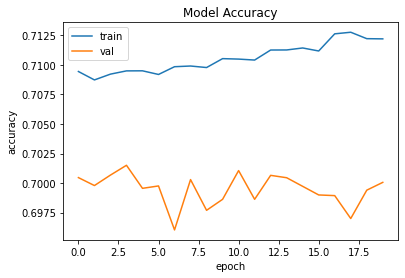

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

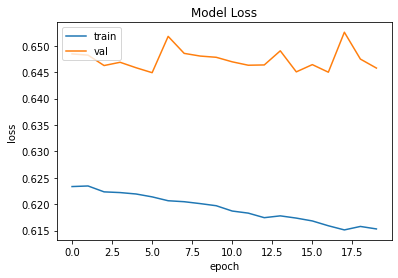

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
file_prefix = "/content/gdrive/MyDrive/CS520/agent_30_nn_conv_"
timestamp = str(dt.datetime.now()).replace(' ', '_')
fname = file_prefix + timestamp

fname

'/content/gdrive/MyDrive/CS520/agent_30_nn_conv_2021-12-16_03:19:52.552450'

In [ ]:
model.save(fname)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/CS520/agent_30_nn_conv_2021-12-16_03:19:52.552450/assets
